In [1]:
%matplotlib inline
import xlrd
import operator
import math
import re
import nltk
import scipy
import random
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from functools import reduce
import seaborn as sns
from pactools.grid_search import GridSearchCVProgressBar
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from ast import literal_eval
from tqdm import tqdm

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

pd.options.mode.chained_assignment = None

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
def importdata(file):
    df = pd.read_csv(file, index_col=0)
    df = df.loc[df['speech category'] == 'Main Speech']
    return df 
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.drop(columns=['tags'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


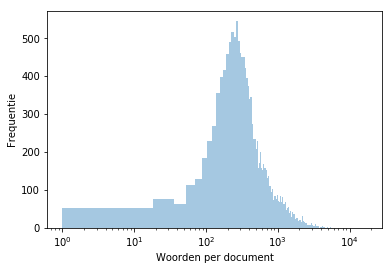

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
ax.set(xlabel='Woorden per document', ylabel='Frequentie')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


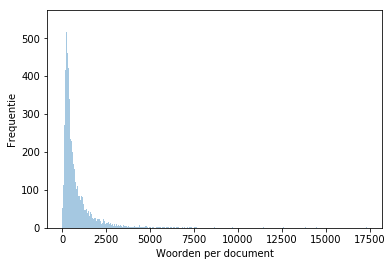

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
ax.set(xlabel='Woorden per document', ylabel='Frequentie')
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("Ondergrens:",math.exp(fit[0]+2*fit[1]),"\nBovengrens:",math.exp(fit[0]-2*fit[1]))
print("Mediaan",np.median([len(doc) for doc in list_text]),"\nGemiddelde",np.mean([len(doc) for doc in list_text]))
print("Overgebleven documenten:",len(df))

Ondergrens: 1492.675589876518 
Bovengrens: 27.339307082607387
Mediaan 386.0 
Gemiddelde 498.18961004094234
Overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string

# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


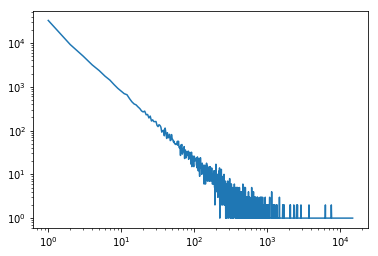

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
del list_text
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       387
         CDA       0.12      0.12      0.12      1901
ChristenUnie       0.07      0.08      0.08      1068
         D66       0.13      0.13      0.13      1889
  GroenLinks       0.07      0.07      0.07      1068
         PVV       0.12      0.12      0.12      1700
        PvdA       0.12      0.12      0.12      1821
        PvdD       0.04      0.03      0.04       432
         SGP       0.06      0.05      0.06       655
          SP       0.16      0.15      0.15      2284
         VVD       0.11      0.11      0.11      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(file,only_doen=False):
    models_df = pd.read_excel(file, index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [11]:
models_df, models_dict = modelsdownload('Models.xlsx',True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}


In [12]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    print("Bezig: %s" %name)
    text = df.stemmed_text if text_dict[name] else df.normal_text
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_excel('Scores.xlsx', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

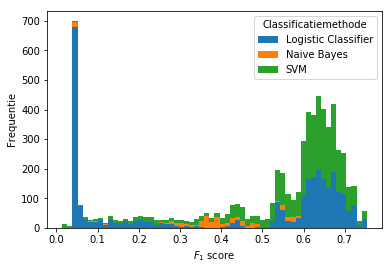

In [13]:
scoresdf = pd.read_excel('Scores.xlsx', index_col=0)
def scoresnames(name):
    if "SVM" in name:
        return "SVM"
    elif "LogisticClassifier" in name:
        return "Logistic Classifier"
    else:
        return "Naive Bayes"
scoresdf.name = scoresdf.name.apply(scoresnames)
scoresdf = scoresdf[['name','mean_test_f1_weighted']]
scoresdf.columns = ['Classificatiemethode','mean_test_f1_weighted']
scoresdf=scoresdf.pivot(index=scoresdf.index, columns='Classificatiemethode')['mean_test_f1_weighted']
ax = scoresdf.plot(kind='hist',stacked=True,bins=60)
ax.set_ylabel("Frequentie")
ax.set_xlabel(r"$F_1$ score")
plt.savefig("Verslag/Tables/scores.png")
#print(scoresdf.name.unique())
#sns.distplot(scoresdf.mean_test_f1_weighted,kde=False)

# Best Score

In [14]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [15]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classification_report_csv(real,predicted):
    report = classification_report(real, predicted)
    report_data = []
    lines = report.split('\n')
    for line in lines[0:-1]:
        row = {}
        row_data = line.split('     ')
        if len(row_data)<5:
            continue
        row['Partij'] = row_data[-5].replace(" ","")
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1 score'] = float(row_data[-2])
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df = df.reindex(["Partij","Precision","Recall",'F1 score',"Documenten"], axis=1).set_index('Partij')
    as_list = df.index.tolist()
    idx = as_list.index('avg/total')
    as_list[idx] = 'Totaal'
    df.index = as_list
    return df

In [16]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_excel(file, index_col=0).sort_values(['mean_test_f1_weighted'], ascending=False).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload('Models.xlsx',False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

In [17]:
def traintest3(pipe, text, data, save=False):
    train, test = train_test_split(data, test_size=0.2)
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return [pipe, cnf_matrix, report, accuracy, indices]
    

def traintest(file, data, save=False, params=None, stemmed="stemmed_text",normal="normal_text"):
    n=5
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    text = stemmed if stem else normal
    pipelist, cnflist, reportlist, accuracylist, indiceslist = zip(*[traintest3(base_pipe, text, data, save=False) for x in tqdm(range(n))])
    accuracy = np.mean(accuracylist)
    cnf_matrix = np.mean(cnflist, axis=0)
    #https://stackoverflow.com/questions/45983321/sum-a-list-of-pandas-dataframes?rq=1
    report = reduce(lambda x, y: x.add(y, fill_value=0), reportlist)
    nlist =Counter(chain.from_iterable([x[x['F1 score']!=0.0].index.values for x in reportlist]))
    report = report.divide(pd.Series(nlist),axis=0)
    report=report.round(2)
    report.Documenten = report.Documenten.round(0).astype(int)
    print(report)
    print(accuracy)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipelist[0], indiceslist

In [18]:
def mostimportantwords(pipe, countdf, filename=None):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = [[inv_vocab[t] for t in coefs[i].argsort()[-100:][::-1]] for i in range(coefs.shape[0])]
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    if filename!=None:
        with open("Verslag/Tables/%s1.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,:5].head(10).to_latex(index=False))
        with open("Verslag/Tables/%s2.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,5:].head(10).to_latex(index=False))
        top_words.to_excel("%s.xlsx" %filename)
        
    return top_words.head(10)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [18:53<00:00, 226.65s/it]


              Precision  Recall  F1 score  Documenten
50PLUS             0.97    0.88      0.92          79
CDA                0.78    0.80      0.79         369
ChristenUnie       0.88    0.76      0.82         225
D66                0.76    0.77      0.76         381
GroenLinks         0.90    0.73      0.81         220
PVV                0.83    0.86      0.84         337
PvdA               0.73    0.73      0.73         361
PvdD               0.89    0.86      0.87          84
SGP                0.86    0.85      0.86         137
SP                 0.76    0.86      0.81         448
Totaal             0.80    0.80      0.80        2980
VVD                0.76    0.76      0.76         339
0.7957046979865772


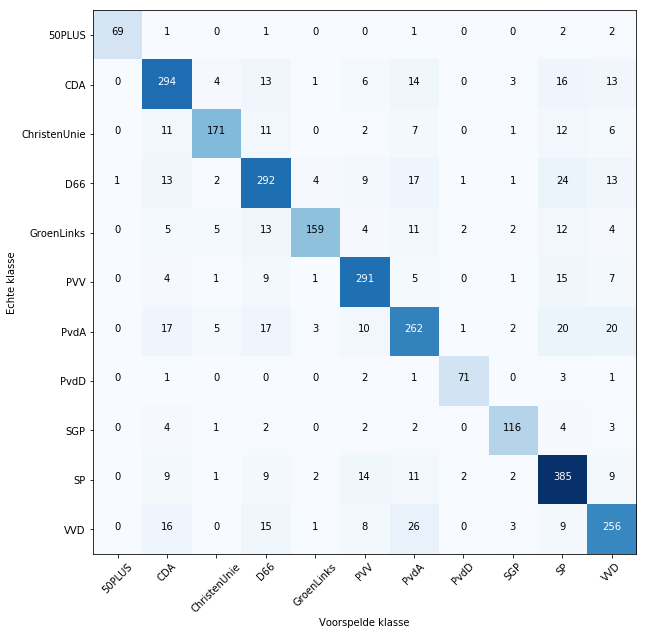

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlinks,pvv,de pvda,lid ouwehand,sgp,sp,de vvd
1,lid krol naar,het cda,christenunie,mijn fractie,lid van tongeren,de pvv,pvda,lid ouwehand naar,de sgp,de sp,vvd
2,het lid krol,de cda,lid dik faber,leden van veldhoven,lid voortman naar,islamitische,van de arbeid,het lid ouwehand,sgp fractie,sp fractie,de vvd fractie
3,lid krol,cda fractie,het lid dik,lid van meenen,het lid voortman,miljard,de arbeid,ouwehand,leden dijkgraaf,de sp fractie,vvd fractie
4,krol naar mij,de cda fractie,lid dik,van veldhoven,lid voortman,klever,de partij van,ouwehand naar,de leden dijkgraaf,lid van gerven,de vvd is
5,krol naar,lid omtzigt,dik faber,veldhoven,voortman,graaf,partij van de,ouwehand naar mij,de sgp fractie,smaling,vvd is
6,krol,het lid omtzigt,faber,lid van veldhoven,tongeren,nederland,partij van,voor de dieren,leden van der,gerven,voor de vvd
7,van 50plus,lid omtzigt naar,leden voordewind,leden schouw,van tongeren,pvv fractie,arbeid,de dieren,mevrouw de voorzitter,van gerven,wat de vvd
8,gepensioneerden,omtzigt naar,de leden voordewind,de leden schouw,leden van tongeren,de pvv fractie,pvda fractie,dieren,mevrouw de,gerven naar mij,de vvd wil
9,ouderen,omtzigt naar mij,dik,d66 is,de leden voortman,madlener naar mij,de pvda fractie,de partij voor,dijkgraaf,gerven naar,vvd betreft


In [19]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="confusionmatrix",params= {'SGD__max_iter':100})
mostimportantwords(pipe, countdf, filename='MostImportantWords')

# What went wrong

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


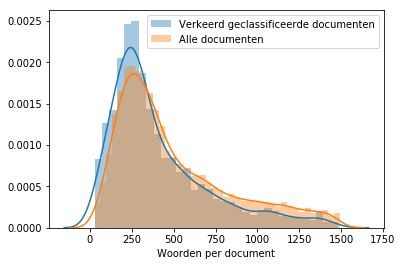

310.0


In [20]:
missclassdocs = df.loc[chain.from_iterable(indiceslist)]
np.mean([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
np.median([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
fig, ax = plt.subplots()
for a,l in [(missclassdocs.stemmed_text.apply(lambda x:len(x.split(" "))),'Verkeerd geclassificeerde documenten'), ((df.stemmed_text.apply(lambda x:len(x.split(" ")))),'Alle documenten')]:
    sns.distplot(a, kde=True, norm_hist=True, label=l, axlabel='Woorden per document')
plt.legend()
plt.savefig("Verslag/Tables/misclassifiedlengths.png")
plt.show()
print(np.median([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))]))

In [21]:
print(len(df[df['titel'].str.contains("Vragen van het lid")])/len(df))
print(len(missclassdocs[missclassdocs['titel'].str.contains("Vragen van het lid")])/len(missclassdocs))
print(np.median([len(doc) for doc in df[df['titel'].str.contains("Vragen van het lid")].stemmed_text.apply(lambda x: x.split(" "))]))


0.045640647023290154
0.08015768725361366
286.0


(-0.3476108345946992, 9.542016413707417e-07)

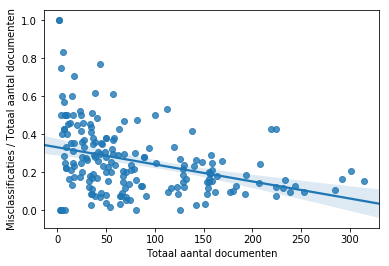

In [22]:
falsedocs = pd.concat([missclassdocs.groupby('surname').party.count(),df.groupby('surname').party.count(),missclassdocs.groupby('surname').party.count()/df.groupby('surname').party.count() ], axis=1)
falsedocs.to_excel('False.xlsx')
falsedocs.columns = ['a','b','c']
falsedocs.fillna(0,inplace=True)
ax = sns.regplot(x=falsedocs.b, y=falsedocs.c)
ax.set(xlabel = 'Totaal aantal documenten', ylabel = 'Misclassificaties / Totaal aantal documenten')
plt.savefig("Verslag/Tables/misclassifiedsprekers.png")
scipy.stats.pearsonr(falsedocs.b, falsedocs.c)

# Without Names

In [23]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
del temp

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [18:43<00:00, 224.71s/it]


              Precision  Recall  F1 score  Documenten
50PLUS             0.86    0.53      0.66          80
CDA                0.54    0.53      0.54         377
ChristenUnie       0.66    0.47      0.55         215
D66                0.55    0.55      0.56         372
GroenLinks         0.67    0.40      0.50         210
PVV                0.61    0.80      0.69         349
PvdA               0.51    0.49      0.50         358
PvdD               0.75    0.69      0.72          81
SGP                0.76    0.71      0.74         142
SP                 0.52    0.69      0.59         448
Totaal             0.59    0.58      0.58        2980
VVD                0.55    0.50      0.53         347
0.5790604026845638


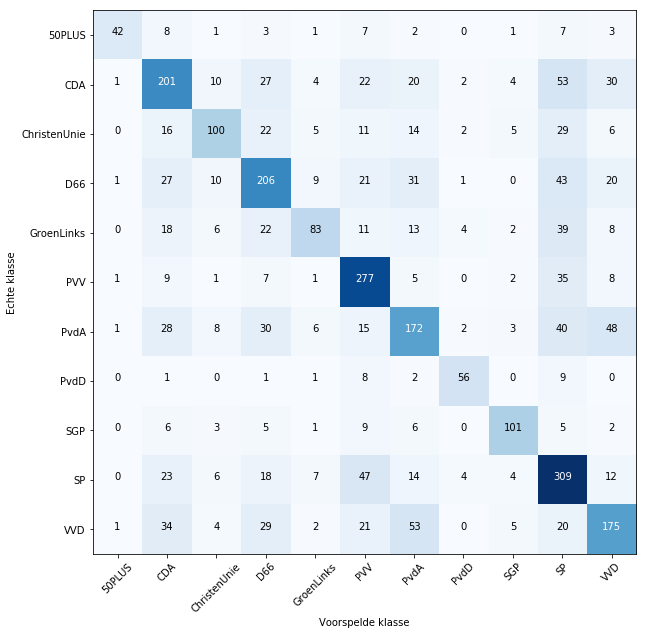

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,ouderen,PARTIJ fractie,dementie,mijn fractie,belastingontwijking,islamitische,en,dieren,mevrouw de voorzitter,zegt,PARTIJ
1,gepensioneerden,inwoners,gezinnen,mijn,zou,nederland,jongeren,natuur,mevrouw de,mening dat,volgens mij
2,plussers,regering,zullen,natuurlijk,kamer hierover te,miljard,daarbij,constaterende,beantwoording,van mening dat,PARTIJ fractie
3,50 plussers,PARTIJ,vluchtelingen,fractie,persoonsgebonden,natuurlijk,tevens,constaterende dat,voor de beantwoording,bezuinigingen,aruba
4,oudere,de regering,ik hoop,het kabinet,in elk geval,islam,vragen,dierenwelzijn,bewindslieden,mensen,regelgeving
5,koopkrachtontwikkeling,diverse,inderdaad,buitengewoon,elk geval,de islam,wij,bio industrie,de beantwoording,huurders,aangegeven
6,50,hier,motie,belangrijk,vluchtelingen,al,beter,industrie,wel,voorstellen,speelveld
7,werkenden,echt,hoop,vandaag,in elk,dit kabinet,kinderen,de bio,punt,segregatie,volgens
8,PARTIJ,een aantal,begeleiding,kabinet,hierover te informeren,brussel,samen,dierproeven,nadrukkelijk,van mening,essentieel
9,overwegende dat,fractie,horeca,daarom,budget,asielzoekers,toezeggingen,de bio industrie,je,bestuurders,en


In [24]:
pipe, indiceslist = traintest('Scores.xlsx', df, save="withoutnames",params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
mostimportantwords(pipe, countdf, filename='MostImportantWordsWithoutNames')

# Only Names

In [25]:
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen = re.compile('|'.join(partijnamen))
df["names"] = df.text.apply(lambda x: re.findall(partijnamen, x)+re.findall(kamerlidnamen, x))
df["names"] = df.names.apply(lambda x: ' '.join([y.replace(" ", "") for y in x]).lower())
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text,stemmed_withoutnames,normal_withoutnames,names
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,vvd pvda vvd pvv rutte rutte rutte samsom rutte
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...,samsom rutte rutte samsom rutte samsom
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...,d66 pvda d66 d66 rutte samsom
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...,cda cda cda cda cda pechtold samsom wilders
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...,vvd pvda pvda vvd partijvandearbeid samsom samsom


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]


              Precision  Recall  F1 score  Documenten
50PLUS             0.83    0.87      0.85          82
CDA                0.68    0.64      0.66         377
ChristenUnie       0.63    0.60      0.62         214
D66                0.59    0.54      0.55         382
GroenLinks         0.72    0.67      0.70         231
PVV                0.73    0.69      0.71         338
PvdA               0.56    0.52      0.53         366
PvdD               0.61    0.77      0.65          88
SGP                0.71    0.47      0.56         125
SP                 0.57    0.69      0.62         447
Totaal             0.64    0.62      0.62        2980
VVD                0.65    0.56      0.60         329
0.6195302013422819


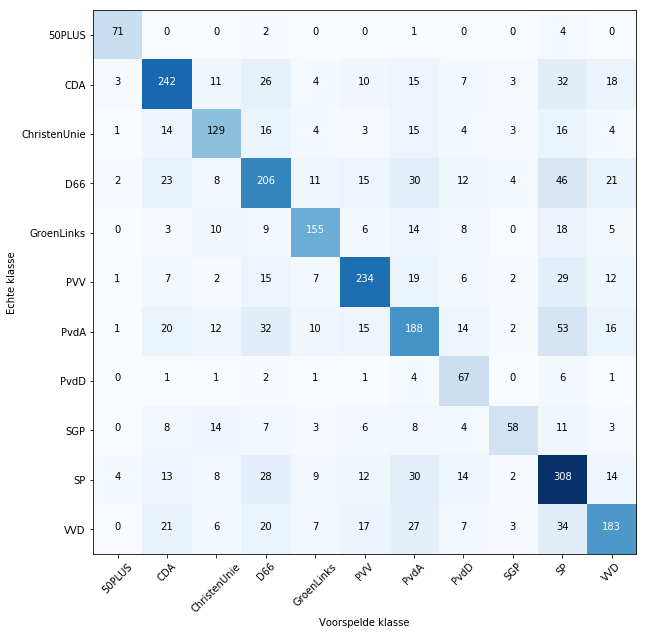

In [26]:
pipe, indiceslist = traintest('Scores.xlsx', df, save = "onlynames", params= {'vect__ngram_range':(1,1),'SGD__max_iter':100}, stemmed='names', normal='names')

In [27]:
mostimportantwords(pipe, countdf, filename='onlynames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,christenunie,d66,groenlinks,pvv,janvos,partijvoordedieren,sgp,jaspervandijk,vvd
1,krol,agnesmulder,dik,piadijkstra,klaver,partijvoordevrijheid,partijvandearbeid,wassenberg,houwers,sp,aukjedevries
2,timmerman,vanhelvert,faber,vanveldhoven,voortman,tonyvandijck,pvda,thieme,vuijk,paulusjansen,rudmerheerema
3,klein,geurts,voordewind,belhaj,vantongeren,klever,albertdevries,ouwehand,welkzijn,smaling,remcodijkstra
4,smits,bruinsslot,bruins,koşerkaya,grashoff,graus,cegerek,pvdd,vanderstaaij,vangerven,straus
5,vanmiltenburg,ronnes,segers,vanmeenen,vanojik,madlener,wolbert,samsom,gezer,leijten,vanveen
6,twout,derouwe,vannieuwenhuizen,koserkaya,ellemeet,degraaf,marcouch,teeven,bisschop,bashir,deliefde
7,van,keijzer,schouten,hachchi,pia,gerbrands,leenders,derouwe,vanmiltenburg,siderius,heerema
8,vanhaersmabuma,vanhaersmabuma,slob,bergkamp,vuijk,fritsma,vandekken,wilders,socialistischepartij,kooiman,annemulder
9,arib,amhaouch,hilkens,sjoerdsma,smits,deroon,jadnanansing,recourt,öztürk,karabulut,ziengs


# Confusion matrix analyse

In [28]:
G = nx.Graph()
G.add_edges_from([(8,10), (10,1),(1,5),(5,2),(2,3),(3,0),(0,7),(7,6),(6,4),(4,9)])
F = nx.Graph()
F.add_weighted_edges_from([(8,10,3.971), (10,1,4.928),(1,5,2.059),(5,2,5.439),(2,3,10.981),(3,0,5.533),(0,7,0.154),(7,6,0.093),(6,4,3.026),(4,9,11.342)])

In [29]:
def traintest2(file, data, save=False,params=None,stemmed="stemmed_text",normal="normal_text"):
    train, test = data
    pipe, stem = getbestpipe(file)
    if params!=None:
        pipe.set_params(**params)
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    cm = confusion_matrix(test.party, predicted)
    tot = len(predicted)
    ggg = defaultdict(int)
    ideology = defaultdict(list)
    ideologyw = defaultdict(list)
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                a = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=a
                if i in [6,10] and j in [6,10]:
                    regering.append(cm[i,j]-a)
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(cm[i,j]-a)
                else:
                    mix.append(cm[i,j]-a)
                ideology[nx.shortest_path_length(G,i,j)].append(cm[i,j]-a)
                ideologyw[nx.dijkstra_path_length(F,i,j)].append(cm[i,j]-a)
    return pipe, oppositie, regering, mix, ggg, ideology,ideologyw

In [30]:
o = []
m = []
r = []
g = {}
ideology2 = []
ideology3 = []
for i in tqdm(range(100)):
    pipe, oppositie, regering, mix, ggg, ideology, ideologyw =traintest2('Scores.xlsx', train_test_split(df, test_size=0.2),params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)
    ideology2.append(ideology)
    ideology3.append(ideologyw)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [6:22:32<00:00, 229.53s/it]


totaal: (0.09862989321547043, 3.4488570011559112e-25)
oppositie: (0.19391201698395166, 5.997943637280226e-62)
mixed: (-0.2697777556264648, 4.499441158029811e-61)


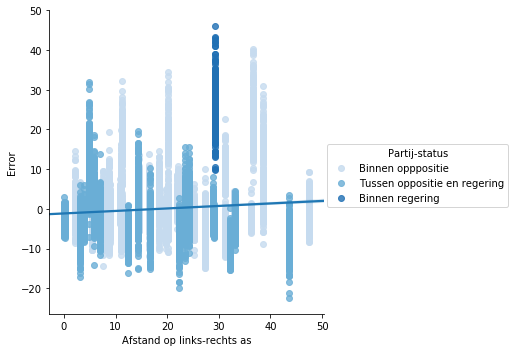

In [31]:
ideology = []
for i in ideology3:
    for j,k in i.items():
        for l in k:
            ideology.append((j,l))

ideology = pd.DataFrame(ideology, columns=['distance','error'])
oppositielist = []
for i in [0,1,2,3,4,5,7,8,9]:
    for j in [0,1,2,3,4,5,7,8,9]:
        oppositielist.append(nx.dijkstra_path_length(F,i,j))
def status(x):
    if x in oppositielist:
        return 'Binnen opppositie'
    elif x==29.187:
        return 'Binnen regering'
    else:
        return 'Tussen oppositie en regering'
ideology['Partij-status'] = ideology.distance.apply(lambda x: status(x))
q= sns.lmplot(x='distance', y='error', hue='Partij-status', data=ideology,fit_reg=False, palette=sns.color_palette("Blues", 3))
ax = sns.regplot(ideology.distance, ideology.error, scatter=False, ax=q.axes[0, 0])
ax.set(xlabel = 'Afstand op links-rechts as', ylabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Ideology.png')
print("totaal:",scipy.stats.pearsonr(ideology.distance,ideology.error))
print("oppositie:",scipy.stats.pearsonr(ideology.loc[ideology['Partij-status'] == 'Binnen opppositie'].distance,ideology.loc[ideology['Partij-status'] == 'Binnen opppositie'].error))
print("mixed:",scipy.stats.pearsonr(ideology.loc[ideology['Partij-status'] == 'Tussen oppositie en regering'].distance,ideology.loc[ideology['Partij-status'] == 'Tussen oppositie en regering'].error))

(0.7533683790738515, 3.69338405649857e-92)

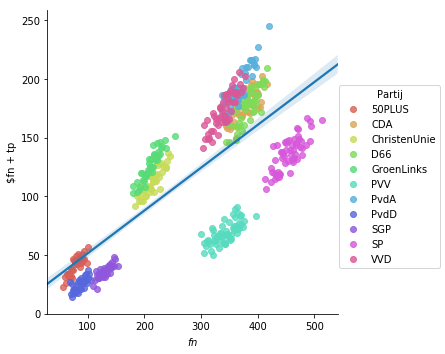

In [32]:
(keys,values) = zip(*g.items())
party, keys = zip(*keys)
keys = pd.Series(keys,name='false negatives + true positives')
values = pd.Series(values,name='false positives')
party = pd.Series(party,name="Partij").replace(dict(enumerate(sorted(df.party.unique()))))
q = sns.lmplot(x='false negatives + true positives', y='false positives', hue='Partij', data=pd.concat([keys, values, party], axis=1),fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(keys, values, scatter=False, ax=q.axes[0, 0])
ax.set_ylabel("$fn + tp")
ax.set_xlabel(r"$fn$")
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean: 0.4313749952397403 6.817556054784077
NormaltestResult(statistic=3129.496498639727, pvalue=0.0)


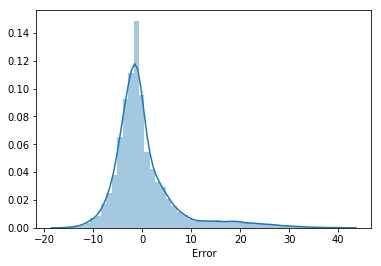

In [57]:
# Dit gebruiken
ax = sns.distplot(list(chain.from_iterable(o)),kde=True)
ax.set(xlabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
print("Mean:",np.mean(list(chain.from_iterable(o))), np.std((list(chain.from_iterable(o)))))
print(scipy.stats.normaltest(list(chain.from_iterable((o-np.mean(o))/np.std(o)))))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean: 26.10731967855254 6.913457830114764
NormaltestResult(statistic=2.093592375351153, pvalue=0.35106068185690376)


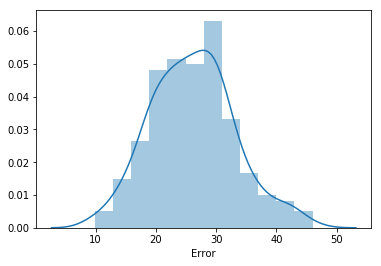

In [58]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=True)
ax.set(xlabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))
print("Mean:",np.mean(list(chain.from_iterable(r))), np.std((list(chain.from_iterable(r)))))
print(scipy.stats.normaltest(list(chain.from_iterable((r-np.mean(r))/np.std(r)))))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean: -2.3131566392879552 6.369473588566722
NormaltestResult(statistic=547.5558231584939, pvalue=1.2582407146150121e-119)


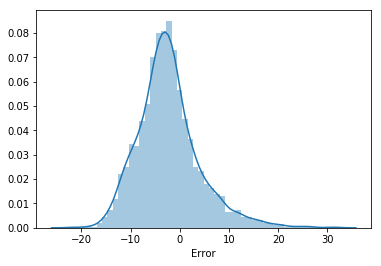

In [59]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=True)
ax.set(xlabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))
print("Mean:",np.mean(list(chain.from_iterable(m))), np.std((list(chain.from_iterable(m)))))
print(scipy.stats.normaltest(list(chain.from_iterable((m-np.mean(m))/np.std(m)))))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean: 0.0 7.670379381213457
NormaltestResult(statistic=4246.030051985548, pvalue=0.0)


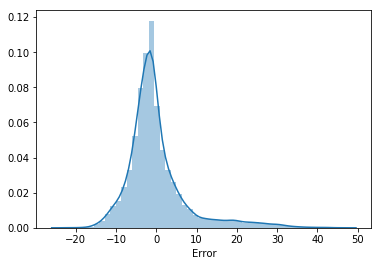

In [60]:
ax = sns.distplot(list(chain.from_iterable(m+o+r)),kde=True)
ax.set(xlabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
print("Mean:",np.mean(list(chain.from_iterable(m+o+r))), np.std((list(chain.from_iterable(m+o+r)))))
print(scipy.stats.normaltest(((list(chain.from_iterable(m+o+r)))-np.mean(list(chain.from_iterable(m+o+r))))/np.std(list(chain.from_iterable(m+o+r)))))

In [37]:
# https://stackoverflow.com/questions/15984221/how-to-perform-two-sample-one-tailed-t-test-with-numpy-scipy
print("R:", scipy.stats.mannwhitneyu(list(chain.from_iterable(r)),list(chain.from_iterable(m)),alternative='greater'))
print("O:", scipy.stats.mannwhitneyu(list(chain.from_iterable(o)),list(chain.from_iterable(m)),alternative='greater'))


R: MannwhitneyuResult(statistic=717034.0, pvalue=7.131163489445915e-124)
O: MannwhitneyuResult(statistic=16248882.0, pvalue=3.8836805393231364e-103)


# Woorden Balkenende 4

In [38]:
# Importing data
dfb4 = importdata("HandelingenBalkenende4.csv")
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]

In [39]:
# Creates a dataframe with counts of dataset per party
countdfb4 = pd.concat([dfb4.party.value_counts(),dfb4[dfb4['titel'].str.contains("Vragen van het lid")].party.value_counts(), dfb4[~dfb4['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdfb4.columns = ['Totaal', 'Vragenuur','Debat']
countdfb4 = countdfb4.sort_values("Totaal",axis=0, ascending=False)
countdfb4 = countdfb4.sort_index()
with open("Verslag/Tables/SpreekbeurtenBal.tex", "w") as f:
    f.write(countdfb4.to_latex(header=True))
countdfb4

,Totaal,Vragenuur,Debat
CDA,1039,53,986
ChristenUnie,561,3,558
D66,518,22,496
GroenLinks,760,50,710
PVV,971,56,915
PvdA,903,22,881
PvdD,165,3,162
SGP,507,6,501
SP,1222,70,1152
VVD,1041,55,986


In [40]:
simpleprediction = np.random.choice(countdfb4.index, len(dfb4.party), p = [x/countdfb4["Totaal"].sum() for x in list(countdfb4['Totaal'])])
print(classification_report(dfb4.party, simpleprediction))
print("Accuracy:",accuracy_score(dfb4.party, np.full(len(dfb4.party), countdfb4["Totaal"].idxmax())))

              precision    recall  f1-score   support

         CDA       0.11      0.11      0.11      1039
ChristenUnie       0.07      0.07      0.07       561
         D66       0.05      0.05      0.05       518
  GroenLinks       0.09      0.09      0.09       760
         PVV       0.14      0.14      0.14       971
        PvdA       0.11      0.11      0.11       903
        PvdD       0.02      0.02      0.02       165
         SGP       0.07      0.07      0.07       507
          SP       0.16      0.16      0.16      1222
         VVD       0.15      0.14      0.14      1041

 avg / total       0.11      0.11      0.11      7687

Accuracy: 0.15896968908546896


In [41]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
dfb4['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:42<00:00, 104.56s/it]


              Precision  Recall  F1 score  Documenten
CDA                0.46    0.68      0.55         212
ChristenUnie       0.61    0.47      0.53         110
D66                0.75    0.38      0.50          98
GroenLinks         0.61    0.53      0.57         153
PVV                0.68    0.66      0.67         201
PvdA               0.46    0.40      0.43         182
PvdD               0.72    0.46      0.55          30
SGP                0.78    0.81      0.80         100
SP                 0.51    0.65      0.57         249
Totaal             0.57    0.55      0.55        1538
VVD                0.48    0.39      0.43         202
0.5550065019505851


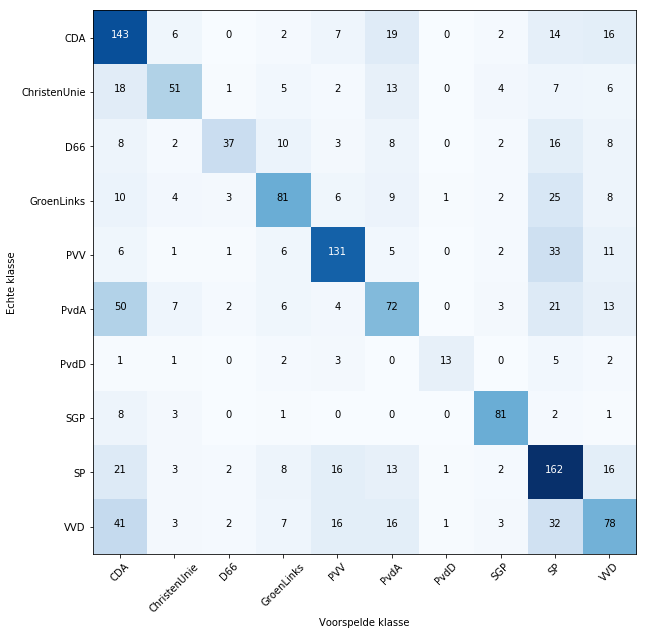

In [42]:
pipe, indiceslist = traintest('Scores.xlsx', dfb4, normal = 'normal_withoutnames', stemmed='stemmed_withoutnames',params= {'SGD__max_iter':100})

In [43]:
mostimportantwords(pipe, countdfb4, 'WoordenBalkenende4')

,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,PARTIJ fractie,fractie van PARTIJ,premier,PARTIJfractie,burgers,vrouwen,dieren,mijn fractie,mensen,PARTIJ
1,wij,de fractie van,de premier,fractie van PARTIJ,onze,wij,bio industrie,wel,zegt,PARTIJ fractie
2,fractie,de fractie,hij,de fractie,burger,belangrijk,dierenwelzijn,beantwoording,leerlingen,onze fractie
3,wij hebben,fractie van,ik hoop,de fractie van,gewoon,kinderen,bio,voorzitter ik wil,is,fractie
4,aangegeven,moment,arbeidsmarkt,fractie van,natuurlijk,goed,de bio industrie,toch,niet,ondernemers
5,PARTIJ fractie heeft,mijn fractie,plannen,premier,de burgers,vragen,de bio,diverse,vandaar,je
6,dank,verschillende,hoop,mij,door,antwoorden,natuur,de bewindslieden,verdrag,praten
7,overleg,beantwoording,de arbeidsmarkt,ik,politie,medewerkers,dierproeven,allerlei,personeel,markt
8,KAMERLID,PARTIJfractie,dadelijk,politieke,land,ben,veehouderij,natuurlijk,problemen,dat
9,buitengewoon,blij,ministerie,en,niet,iedereen,industrie,bewindslieden,waarom,voorzitter PARTIJ fractie


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [17:05<00:00, 205.03s/it]


              Precision  Recall  F1 score  Documenten
CDA                0.56    0.54      0.55         379
ChristenUnie       0.70    0.46      0.56         221
D66                0.55    0.54      0.55         381
GroenLinks         0.65    0.40      0.50         214
PVV                0.61    0.79      0.69         334
PvdA               0.54    0.49      0.51         367
PvdD               0.74    0.70      0.72          86
SGP                0.79    0.76      0.78         131
SP                 0.54    0.70      0.61         458
Totaal             0.59    0.59      0.58        2903
VVD                0.54    0.51      0.53         331
0.5844987943506716


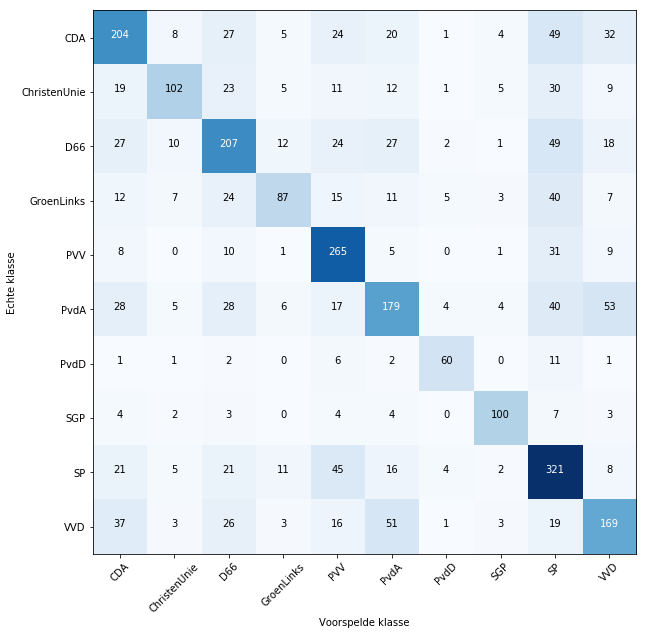

In [44]:
pipe, indiceslist = traintest('Scores.xlsx', df[df.party != '50PLUS'],params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')

In [45]:
# Creates a dataframe with counts of dataset per party
dfz5 = df[df.party != '50PLUS']
countdfz5 = pd.concat([dfz5.party.value_counts(),dfz5[dfz5['titel'].str.contains("Vragen van het lid")].party.value_counts(), dfz5[~dfz5['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdfz5.columns = ['Totaal', 'Vragenuur','Debat']
countdfz5 = countdfz5.sort_values("Totaal",axis=0, ascending=False)
countdfz5 = countdfz5.sort_index()
countdfb4

,Totaal,Vragenuur,Debat
CDA,1039,53,986
ChristenUnie,561,3,558
D66,518,22,496
GroenLinks,760,50,710
PVV,971,56,915
PvdA,903,22,881
PvdD,165,3,162
SGP,507,6,501
SP,1222,70,1152
VVD,1041,55,986


In [46]:
simpleprediction = np.random.choice(countdfz5.index, len(dfz5.party), p = [x/countdfz5["Totaal"].sum() for x in list(countdfz5['Totaal'])])
print(classification_report(dfz5.party, simpleprediction))
print("Accuracy:",accuracy_score(dfz5.party, np.full(len(dfz5.party), countdfz5["Totaal"].idxmax())))

              precision    recall  f1-score   support

         CDA       0.13      0.13      0.13      1901
ChristenUnie       0.08      0.09      0.08      1068
         D66       0.12      0.12      0.12      1889
  GroenLinks       0.07      0.07      0.07      1068
         PVV       0.11      0.11      0.11      1700
        PvdA       0.13      0.13      0.13      1821
        PvdD       0.03      0.03      0.03       432
         SGP       0.04      0.04      0.04       655
          SP       0.15      0.15      0.15      2284
         VVD       0.12      0.12      0.12      1694

 avg / total       0.11      0.11      0.11     14512

Accuracy: 0.15738699007717752


# Vergelijken

In [47]:
def traintest5(file, data, save=False, stemmed="stemmed_text",normal="normal_text",params=None):
    pipe, stem = getbestpipe(file)
    if params!=None:
        pipe.set_params(**params)
    train, test = data
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    print(report)
    print(accuracy_score(test.party, predicted))
    cnf_matrix = confusion_matrix(test.party, predicted)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(train.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())
    return pipe

              Precision  Recall  F1 score  Documenten
CDA                0.28    0.31      0.30        1039
ChristenUnie       0.43    0.19      0.27         561
D66                0.16    0.26      0.20         518
GroenLinks         0.32    0.03      0.06         760
PVV                0.48    0.61      0.54         971
PvdA               0.28    0.30      0.29         903
PvdD               0.65    0.49      0.56         165
SGP                0.54    0.55      0.55         507
SP                 0.41    0.54      0.47        1222
VVD                0.19    0.17      0.18        1041
Totaal             0.35    0.34      0.33        7687
0.344998048653571


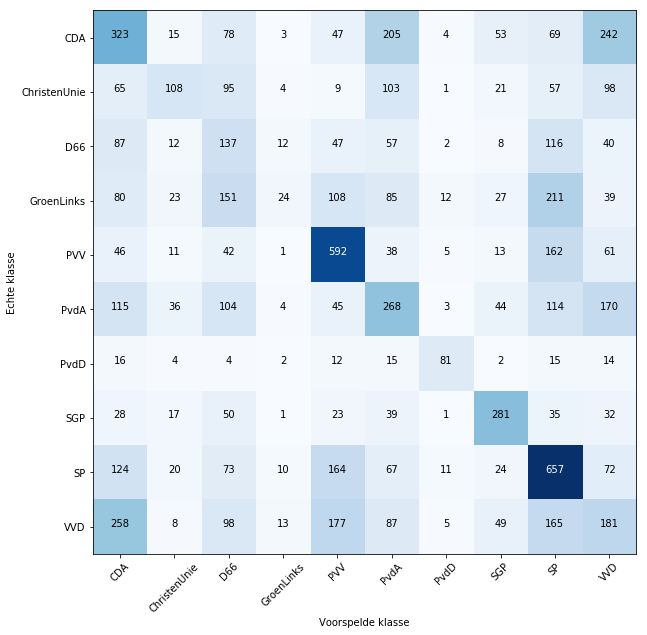

In [48]:
pipe = traintest5('Scores.xlsx', (df[df.party != '50PLUS'],dfb4), save="RutToBal", stemmed="stemmed_withoutnames", normal="normal_withoutnames",params= {'SGD__max_iter':100})

              Precision  Recall  F1 score  Documenten
CDA                0.20    0.40      0.27        1901
ChristenUnie       0.24    0.12      0.16        1068
D66                0.26    0.10      0.15        1889
GroenLinks         0.16    0.07      0.10        1068
PVV                0.51    0.52      0.51        1700
PvdA               0.27    0.25      0.26        1821
PvdD               0.72    0.19      0.30         432
SGP                0.47    0.43      0.45         655
SP                 0.34    0.59      0.43        2284
VVD                0.21    0.11      0.14        1694
Totaal             0.30    0.30      0.28       14512
0.3031973539140022


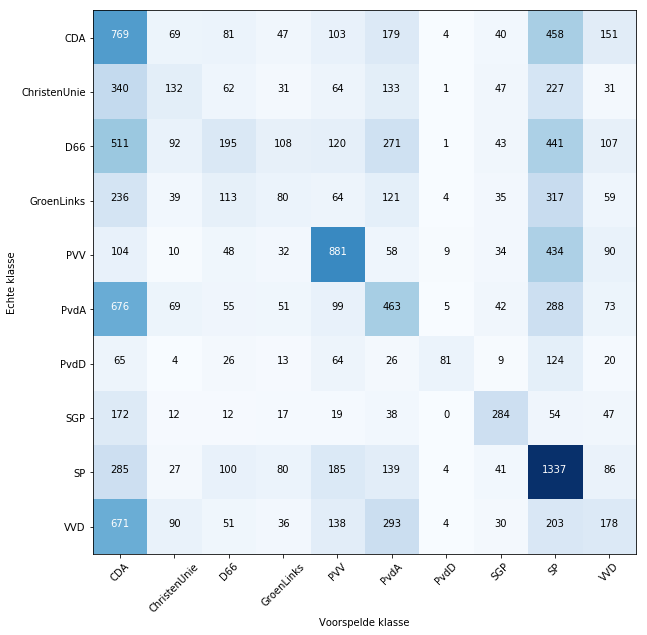

In [49]:
pipe = traintest5('Scores.xlsx', (dfb4,df[df.party != '50PLUS']), save="BalToRut", stemmed="stemmed_withoutnames", normal="normal_withoutnames",params= {'SGD__max_iter':100})

In [50]:
woordenBalk = pd.read_excel('WoordenBalkenende4.xlsx', index_col=0)
woordenRut = pd.read_excel('MostImportantWordsWithoutNames.xlsx', index_col=0)
commondict = defaultdict(dict)
for partyB in ["PvdA", "ChristenUnie", "CDA"]:
    for partyR in ["VVD", "PvdA"]:
        commondict[partyB][partyR] = [x for x in set(woordenBalk[partyB])&set(woordenRut[partyR]) - set(woordenBalk[partyR]) - set(woordenRut[partyB])]
commondict

defaultdict(dict,
            {'CDA': {'PvdA': ['samen', 'hun', 'kan worden', 'toezeggingen'],
              'VVD': ['helder',
               'toezegging',
               'daadwerkelijk',
               'aangegeven',
               'algemeen overleg',
               'algemeen']},
             'ChristenUnie': {'PvdA': ['over', 'blij'],
              'VVD': ['beantwoording',
               'volgens',
               'termijn',
               'volgens mij',
               'blij']},
             'PvdA': {'PvdA': [], 'VVD': ['volgens mij']}})

In [51]:
oppositiewoorden = woordenBalk.drop(["PvdA", "ChristenUnie", "CDA"], axis=1).values.flatten()
pointlesswords = ["in","men","de"]
for partyB in ["PvdA","CDA", "ChristenUnie"]:
    for partyR in ["PvdA", "ChristenUnie", "CDA"]:
        if partyR!=partyB:
            for word in woordenBalk[partyR]:
                for word2 in woordenBalk[partyB]:
                    if word in word2 and word not in pointlesswords and word2 not in pointlesswords and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        #print(partyB, "->",partyR,":",word,",", word2)
                        continue

In [52]:
oppositiewoorden = woordenRut.drop(['VVD', 'PvdA'], axis=1).values.flatten()
for partyB in ["PvdA", "VVD"]:
    for partyR in ["VVD", "PvdA"]:
        if partyR!=partyB:
            for word in woordenRut[partyR]:
                for word2 in woordenRut[partyB]:
                    if word in word2 and word not in ["en","in","men"] and word2 not in ["en","in","men"] and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        print(partyB, "->",partyR,":",word,",", word2)

PvdA -> VVD : zijn , met zijn allen
PvdA -> VVD : zijn , zijn allen
PvdA -> VVD : toezegging , toezeggingen
PvdA -> VVD : blij , blij
PvdA -> VVD : blij , erg blij
PvdA -> VVD : blij , blij dat
VVD -> PvdA : beter , verbetercultuur
VVD -> PvdA : blij , blij


# Taalgebruik van sprekers

In [53]:
def traintest3(pipe, text, data, save=False):
    trainsprekers, testsprekers = train_test_split(data.surname.unique(), test_size=0.2)
    train = data[data['surname'].isin(trainsprekers)]
    test = data[data['surname'].isin(testsprekers)]
     
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return pipe, cnf_matrix, report, accuracy, indices

def traintest(file, data, save=False, params=None, stemmed="stemmed_text",normal="normal_text"):
    n=10
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    text = stemmed if stem else normal
    pipelist, cnflist, reportlist, accuracylist, indiceslist = zip(*[traintest3(base_pipe, text, data, save=False) for x in tqdm(range(n))])
    accuracy = np.mean(accuracylist)
    cnf_matrix = np.mean(cnflist, axis=0)
    #https://stackoverflow.com/questions/45983321/sum-a-list-of-pandas-dataframes?rq=1
    report = reduce(lambda x, y: x.add(y, fill_value=0), reportlist)
    nlist =Counter(chain.from_iterable([x[x['F1 score']!=0.0].index.values for x in reportlist]))
    print(nlist)
    report = report.divide(pd.Series(nlist),axis=0)
    
    report=report.round(2)
    report.Documenten = report.Documenten.round(0).astype(int)
    print(report)
    print(accuracy)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipelist[0], indiceslist

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 10%|████████▏                                                                         | 1/10 [03:44<33:42, 224.72s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 20%|████████████████▍                                                                 | 2/10 [07:37<30:31, 228.99s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: Undef

Counter({'CDA': 10, 'D66': 10, 'PVV': 10, 'PvdA': 10, 'VVD': 10, 'Totaal': 10, 'SP': 9, 'GroenLinks': 7, 'SGP': 5, 'ChristenUnie': 4, 'PvdD': 4, '50PLUS': 3})
              Precision  Recall  F1 score  Documenten
50PLUS             0.91    0.09      0.15         204
CDA                0.14    0.16      0.13         395
ChristenUnie       0.13    0.10      0.06         383
D66                0.24    0.20      0.19         445
GroenLinks         0.25    0.04      0.06         415
PVV                0.33    0.49      0.38         299
PvdA               0.21    0.20      0.20         392
PvdD               0.90    0.13      0.21         274
SGP                0.56    0.07      0.12         311
SP                 0.28    0.34      0.26         524
Totaal             0.32    0.20      0.21        3138
VVD                0.26    0.26      0.24         366
0.20520131026007288


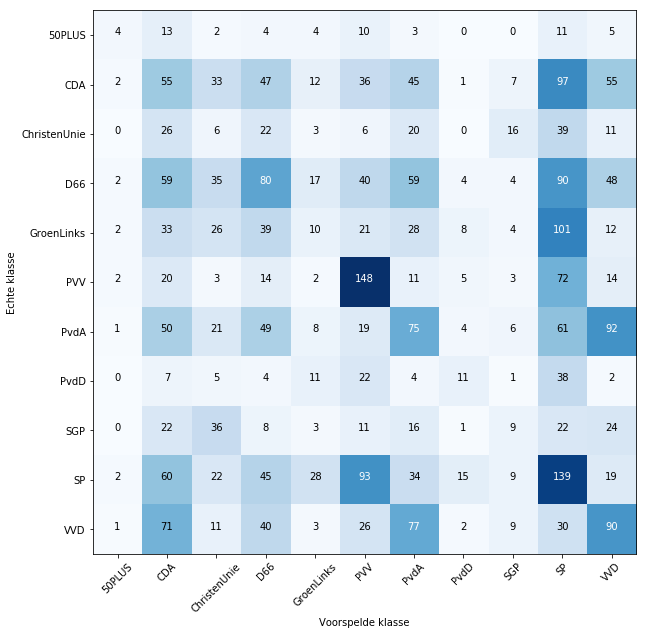

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50,PARTIJ fractie,gezinnen,mijn fractie,zou,islamitische,en,dieren,wijze,zegt,PARTIJ
1,50 plussers,inwoners,mensenhandel,natuurlijk,kamer hierover te,nederland,jongeren,natuur,allereerst,bestuurders,aruba
2,plussers,PARTIJ,inderdaad,mijn,vluchtelingen,natuurlijk,van mening,milieu,beantwoording,de bevolking,helder
3,gepensioneerden,regering,zullen,belangrijk,hierover te informeren,brussel,patiënten,aarde,punt,mensen,speelveld
4,oudere,hier,dementie,het kabinet,in elk geval,miljard,lagere overheden,constaterende,allereerst dank,bevolking,banen
5,50 plusser,de regering,ook,daarom,elk geval,al,kinderen,constaterende dat,voorzitter allereerst dank,mening dat,volgens mij
6,plusser,echt,nu,fractie,hierover te,islam,mening,industrie,even,voorstellen,ondernemers
7,de 50,wij,hoop,minister,in elk,de islam,collega,dierenwelzijn,op,segregatie,essentieel
8,ouderen,diverse,ik hoop,twee,persoonsgebonden,dit kabinet,open standaarden,bio industrie,nadrukkelijk,armoede,aangegeven
9,wij,vandaag,onder,dingen,belastingontwijking,belastingbetaler,toezeggingen,de bio,collega,van mening dat,stelsel


In [54]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="taalgebruik", stemmed='stemmed_withoutnames', normal='normal_withoutnames',params= {'SGD__max_iter':100})
mostimportantwords(pipe, countdf, 'taalgebruik')